In [81]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import os
from ast import literal_eval
from gensim.models import KeyedVectors
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.sparse import hstack

In [82]:
sns.set(font_scale=1.1)

RANDOM_STATE = 12345

def evaluate_classifier(model, X_test, y_test, label_encoder=None):
    labels = list(model.classes_)
    pred = model.predict(X_test) 
    if type(model['clf']) == XGBClassifier:
        pred = label_encoder.inverse_transform(pred)
        labels = label_encoder.inverse_transform(labels)
    fig, ax = plt.subplots(figsize=(8,6))
    # normalize : {'true', 'pred', 'all'}, default=None
    # Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population. 
    # If None, confusion matrix will not be normalized.
    cm = confusion_matrix(y_test, pred, normalize=None) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax)
    plt.grid(False)
    plt.show()
    
    #print(classification_report(y_test, pred))
    print("Accuracy  = " + str(accuracy_score(y_true=y_test, y_pred=pred)))
    print("F1 score  = " + str(f1_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Precision = " + str(precision_score(y_true=y_test, y_pred=pred, average='weighted')))
    print("Recall    = " + str(recall_score(y_true=y_test, y_pred=pred, average='weighted')))

In [83]:
df_train = pd.read_csv('../data/train_data.csv')
df_train['lemmatized'] = df_train['lemmatized'].apply(literal_eval)

df_test = pd.read_csv('../data/test_data.csv')
df_test['lemmatized'] = df_test['lemmatized'].apply(literal_eval)

df_train.head()

,filename,artist,title,genre,lyrics,instrumental,tokenized,lemmatized
0,country.00041.wav,Johnny Cash,Goin' By The Book,country,\nYou can see it in the movies and the paper a...,False,"['see', 'movies', 'paper', 'tv', 'news', 'some...","[see, movie, paper, tv, news, somebody, army, ..."
1,reggae.00038.wav,Burning Spear,Investigation Dub,reggae,I and I old I know\nI and I old I say\nI and I...,False,"['old', 'know', 'old', 'say', 'reconsider', 's...","[old, know, old, say, reconsider, see, upfully..."
2,disco.00070.wav,KC and The Sunshine Band,That's The Way (I Like It),disco,"That's the way, aha, aha\nI like it, aha, aha\...",False,"['thats', 'way', 'aha', 'aha', 'like', 'aha', ...","[thats, way, aha, aha, like, aha, aha, thats, ..."
3,reggae.00088.wav,Marcia Griffiths,Electric Boogie,reggae,\nIt's electric!\n\n\nYou can't see it\nIt's e...,False,"['electric', 'cant', 'see', 'electric', 'got',...","[electric, cant, see, electric, get, ta, feel,..."
4,pop.00017.wav,Britney Spears,(I Can't Get No) Satisfaction,pop,\nI can't get no satisfaction\nI can't get no ...,False,"['cant', 'get', 'satisfaction', 'cant', 'get',...","[cant, get, satisfaction, cant, get, satisfact..."


In [84]:
num_feats = pd.read_csv('../data/features_30_sec.csv')
num_feats = num_feats.drop(columns=['length', 'label'])
num_feats

,filename,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,blues.00000.wav,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,blues.00001.wav,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,blues.00002.wav,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,blues.00003.wav,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,blues.00004.wav,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,4253.557033,...,1.789867,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665
996,rock.00096.wav,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,4149.338328,...,3.739020,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624
997,rock.00097.wav,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,4031.405321,...,1.838090,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515
998,rock.00098.wav,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,3015.631004,...,-2.812176,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088


In [85]:
train_num_feats = pd.merge(num_feats, df_train['filename'], how="inner", on="filename")
test_num_feats = pd.merge(num_feats, df_test['filename'], how="inner", on="filename")
assert len(df_train) == len(train_num_feats)
assert len(df_test) == len(test_num_feats)

In [86]:
X_train_num = train_num_feats.drop(columns=['filename']).to_numpy(dtype='float')
X_test_num = test_num_feats.drop(columns=['filename']).to_numpy(dtype='float')
print(X_train_num.shape)

(609, 57)


In [87]:
X_train_text = df_train['lemmatized']
y_train = df_train['genre']
X_test_text = df_test['lemmatized']
y_test = df_test['genre']

In [88]:
# encode labels for xgboost
label_enc = LabelEncoder()
label_enc = label_enc.fit(y_train)
y_train_enc = label_enc.transform(y_train)

In [89]:
def dummy_fun(doc):
    return doc

vec = TfidfVectorizer(tokenizer=dummy_fun, preprocessor=dummy_fun, max_features=2000)
X_train_enc = vec.fit_transform(X_train_text)
X_test_enc = vec.transform(X_test_text)

# concatenate numerical and text features
X_train_concat = hstack((X_train_num, X_train_enc))
X_test_concat = hstack((X_test_num, X_test_enc))

# GridSearch to find best params

## Random Forest

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best CV score = 0.496 with the following parameters:
{'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 1000}


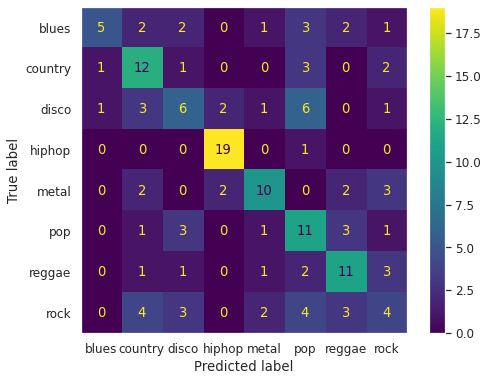

Accuracy  = 0.5098039215686274
F1 score  = 0.49895303792585666
Precision = 0.5167605109676721
Recall    = 0.5098039215686274


In [90]:
pipe = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

params = {
    'clf__n_estimators': [50, 100, 500, 1000],
    'clf__max_depth': [3, 10, None],
    'clf__min_samples_split': [2, 5, 10],
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train_concat, y_train)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test_concat, y_test)

In [ ]:
pipe = Pipeline([
    ('norm', MaxAbsScaler()),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

params = {
    'clf__n_estimators': [50, 100, 500, 1000],
    'clf__max_depth': [3, 10, None],
    'clf__min_samples_split': [2, 5, 10],
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train_concat, y_train)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test_concat, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


## Support Vector Machine

In [ ]:
pipe = Pipeline([
    ('clf', SVC())
])

params = {
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__kernel': ['linear', 'rbf', 'sigmoid'],
    'clf__gamma': ['auto', 'scale', 0.1, 0.001],
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train_concat, y_train)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test_concat, y_test)

In [ ]:
pipe = Pipeline([
    ('norm', MaxAbsScaler()),
    ('clf', SVC())
])

params = {
    'clf__C': [0.1, 1, 10, 100, 1000],
    'clf__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'clf__gamma': ['auto', 'scale', 0.1, 0.001, 1.0],
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train_concat, y_train)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test_concat, y_test)

## XGBoost

yesterday best results was XGBoost with default params -> 52% accuracy

In [ ]:
pipe = Pipeline([
    ('clf', XGBClassifier(random_state=RANDOM_STATE))
])

params = {
    'clf__max_depth': [3, 6, 10],
    'clf__n_estimators': [50, 100, 200, 500],
    'clf__learning_rate': [0.01, 0.1, 0.2],
}

# Setting up GridSearch
search = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1, n_jobs=-1)
# Fitting Gridsearch
search.fit(X_train_concat, y_train_enc)

print("Best CV score = %0.3f with the following parameters:" % search.best_score_)
print(search.best_params_)
evaluate_classifier(search.best_estimator_, X_test_concat, y_test, label_enc)